# 🚴 Route Optimization Analysis

This notebook demonstrates how a delivery company  can save time, fuel, and emissions
by optimizing delivery routes.

We show two case studies:

1. **Random Graph Simulation** — toy example with randomly generated points.  
2. **Real Bengaluru Road Network** — realistic case using OpenStreetMap data.

We solve:
- Travelling Salesman Problem (TSP) for one rider.
- Vehicle Routing Problem (VRP) for multiple riders.

We then compare:
- Distance saved
- Time saved (with traffic/weather factor)
- Fuel saved
- CO₂ emissions reduced

Visualizations: Interactive maps with Folium + heatmaps of delivery demand.


In [ ]:

!pip install osmnx folium ortools matplotlib pandas numpy geopandas

import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from ortools.constraint_solver import routing_enums_pb2, pywrapcp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.7/27.7 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


## 🟢 Part 1: Random Graph Simulation

We start with a random set of delivery points and a restaurant, and
generate distances using the **Haversine formula**.

This is a simplified example to illustrate the optimization process.


Generate Random Customers

In [ ]:
np.random.seed(27)

# Random lat/lon points around Bengaluru center
center = (12.9716, 77.5946)
n_customers = 8

customers = pd.DataFrame({
    "order_id": [f"Cust{i:02d}" for i in range(1, n_customers+1)],
    "lat": center[0] + np.random.uniform(-0.02, 0.02, n_customers),
    "lon": center[1] + np.random.uniform(-0.02, 0.02, n_customers)
})

restaurant = {"order_id": "R", "lat": center[0], "lon": center[1]}
customers = pd.concat([pd.DataFrame([restaurant]), customers], ignore_index=True)
customers


,order_id,lat,lon
0,R,12.971600,77.594600
1,Cust01,12.968629,77.604273
2,Cust02,12.984183,77.601126
3,Cust03,12.981016,77.610072
4,Cust04,12.986320,77.608921
5,Cust05,12.966935,77.604570
6,Cust06,12.990778,77.609406
7,Cust07,12.987328,77.582070
8,Cust08,12.959989,77.587623


Build Distance Matrix (Haversine)

In [ ]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2-lat1)
    dlambda = radians(lon2-lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return R * (2*atan2(sqrt(a), sqrt(1-a)))

n = len(customers)
dist_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i!=j:
            dist_matrix[i,j] = haversine(customers.lat[i], customers.lon[i],
                                         customers.lat[j], customers.lon[j])
dist_matrix[:5,:5]


array([[   0.        , 1098.99282368, 1567.72281801, 1976.56102567,
        2255.40650878],
       [1098.99282368,    0.        , 1762.88231896, 1513.93145904,
        2030.61001201],
       [1567.72281801, 1762.88231896,    0.        , 1031.35967837,
         877.3599639 ],
       [1976.56102567, 1513.93145904, 1031.35967837,    0.        ,
         602.85756336],
       [2255.40650878, 2030.61001201,  877.3599639 ,  602.85756336,
           0.        ]])

Solve TSP (Random Graph)

In [ ]:

from ortools.constraint_solver import routing_enums_pb2, pywrapcp

def solve_tsp(distance_matrix):
    """Solve TSP for a single vehicle starting at depot=0."""
    n = len(distance_matrix)
    manager = pywrapcp.RoutingIndexManager(n, 1, 0)   # 1 vehicle, depot=0
    routing = pywrapcp.RoutingModel(manager)

    # distance callback
    def dist_cb(i, j):
        return int(distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)])

    transit_callback_index = routing.RegisterTransitCallback(dist_cb)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # search parameters
    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    # solve
    solution = routing.SolveWithParameters(params)

    # extract route
    route = []
    if solution:
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))  # return to depot
    return route


In [ ]:
tsp_route = solve_tsp(dist_matrix)
tsp_route

[0, 7, 2, 6, 4, 3, 1, 5, 8, 0]

Visualize Random Graph Route

In [ ]:
# Folium map to show restaurant + customer points and optimized TSP route
m = folium.Map(location=center, zoom_start=14)

# Plot markers
for i, row in customers.iterrows():
    folium.Marker(
        (row.lat, row.lon),
        popup=row.order_id,
        icon=folium.Icon(color="blue" if row.order_id != "R" else "red")
    ).add_to(m)

# Plot TSP route as straight lines
for i in range(len(tsp_route) - 1):
    a, b = tsp_route[i], tsp_route[i + 1]
    folium.PolyLine(
        [(customers.lat[a], customers.lon[a]),
         (customers.lat[b], customers.lon[b])],
        color="green", weight=3
    ).add_to(m)

# Save & display
m.save("maps/random_route.html")
m


## 🟠 Part 2: Real Road Network (Bengaluru)

In the previous section, we solved the Travelling Salesman Problem (TSP) using
**straight-line (Haversine) distances**. While this demonstrates the optimization
concept, it does not reflect reality because delivery riders must follow actual
roads and traffic constraints.

In this section, we repeat the analysis on **real Bengaluru streets** using the
[OSMnx](https://osmnx.readthedocs.io/) library.  
This allows us to:

- Download the drivable road network for a city area.  
- Place one restaurant and multiple customer delivery points on the map.  
- Compute **shortest paths along real roads** instead of straight lines.  
- Solve TSP again to find the most efficient route.  

This approach provides a much more realistic scenario for Swiggy route optimization.


In [ ]:
# Download drivable road network for 2km radius around Bengaluru center
G = ox.graph_from_point(center, dist=2000, network_type="drive")

# Pick one restaurant (nearest node to center) + random customer nodes
restaurant_node = ox.distance.nearest_nodes(G, center[1], center[0])
customer_nodes = np.random.choice(list(G.nodes), 10, replace=False)

# Create DataFrame of delivery points
customers_real = pd.DataFrame([{
    "order_id": f"Cust{i:02d}",
    "lat": G.nodes[node]["y"],
    "lon": G.nodes[node]["x"],
    "node": node
} for i, node in enumerate(customer_nodes, start=1)])


Compute Road-Network Distance Matrix

In [ ]:
# Combine restaurant + customers into a list
all_nodes = [restaurant_node] + customers_real.node.tolist()
n = len(all_nodes)


dist_matrix_real = np.zeros((n, n))

# Compute shortest-path distances on road network
for i in range(n):
    for j in range(n):
        if i != j:
            try:
                dist_matrix_real[i, j] = nx.shortest_path_length(
                    G, all_nodes[i], all_nodes[j], weight="length"
                )
            except nx.NetworkXNoPath:
                dist_matrix_real[i, j] = 1e6  # unreachable penalty

dist_matrix_real[:5, :5]  # preview


array([[   0.        , 2808.04862286, 2055.22369551, 2305.04046276,
        3423.82208387],
       [3439.56924722,    0.        , 3771.14404464, 4364.70515167,
        4341.90585871],
       [2641.26551385, 2639.25387158,    0.        , 4660.98623633,
        5180.37908361],
       [2840.04286154, 4558.03273367, 3837.76406156,    0.        ,
        2867.24948251],
       [4339.08887354, 4397.86097854, 5516.24414143, 3422.77353369,
           0.        ]])

### Understanding the Output (Distance Matrix – Real Road Network)

The matrix shown above is the **road distance matrix** (in meters) between the
restaurant and the first few customer delivery points.  

- Each row and column corresponds to a node (the restaurant or a customer).  
- The value at position `[i, j]` represents the **shortest road distance**
  from location `i` to location `j`, computed along actual Bengaluru streets
  using OSMnx + NetworkX.  
- Diagonal values are `0` because the distance from a node to itself is zero.  
- Example: The distance from the restaurant (row 0) to customer 1 (column 1)
  is `2808.04` meters (~2.8 km).  
- The matrix is not always symmetric because the road network can include
  one-way streets and different shortest paths in each direction.  

This distance matrix becomes the **input for the TSP/VRP solver**, ensuring that
routes are optimized based on real travel distances rather than straight-line
approximations.


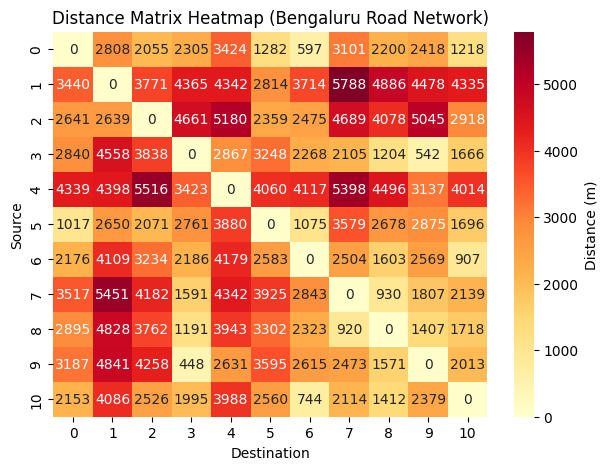

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: using the matrix you already computed
matrix = dist_matrix_real

plt.figure(figsize=(7,5))
sns.heatmap(matrix, annot=True, fmt=".0f", cmap="YlOrRd", cbar_kws={'label': 'Distance (m)'})
plt.title("Distance Matrix Heatmap (Bengaluru Road Network)")
plt.xlabel("Destination")
plt.ylabel("Source")
plt.show()


Solve TSP on Real Network

In [ ]:
tsp_real = solve_tsp(dist_matrix_real)
tsp_real


[0, 6, 10, 8, 7, 3, 9, 4, 1, 2, 5, 0]

In [ ]:
# Create base map
m2 = folium.Map(location=center, zoom_start=14)

# Add restaurant marker
folium.Marker(
    center, popup="Restaurant",
    icon=folium.Icon(color="red")
).add_to(m2)

# Add customer markers
for _, row in customers_real.iterrows():
    folium.Marker(
        (row.lat, row.lon),
        popup=row.order_id,
        icon=folium.Icon(color="blue")
    ).add_to(m2)

# Add optimized TSP path along actual roads
for i in range(len(tsp_real) - 1):
    u, v = all_nodes[tsp_real[i]], all_nodes[tsp_real[i + 1]]
    path = nx.shortest_path(G, u, v, weight="length")
    coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in path]
    folium.PolyLine(coords, color="purple", weight=3).add_to(m2)

# Save & display
m2.save("maps/bangalore_route.html")
m2


## Part 3: Vehicle Routing Problem (VRP) with Multiple Riders

### Business Case

In real-life operations, delivery companies do not rely on a single rider
to deliver all orders. Instead, they dispatch **multiple riders**, each covering
a subset of customers.  

This scenario is modeled as the **Vehicle Routing Problem (VRP)**.  

Solving the VRP provides several key benefits:

- **Faster deliveries** since riders work in parallel.  
- **Less travel per rider**, reducing fatigue and improving efficiency.  
- **Lower overall fuel consumption and CO₂ emissions**, making operations
  more sustainable.  

By applying VRP optimization, companies can significantly improve both customer
experience and operational costs.

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import numpy as np

def solve_vrp_balanced(distance_matrix,
                       demands,
                       vehicle_capacity=10,
                       num_vehicles=2,
                       max_distance_per_vehicle=None,
                       balance_routes=True):
    n = len(distance_matrix)
    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)


    def dist_cb(i, j):
        return int(distance_matrix[manager.IndexToNode(i)][manager.IndexToNode(j)])
    transit_idx = routing.RegisterTransitCallback(dist_cb)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)


    def demand_cb(i):
        return int(demands[manager.IndexToNode(i)])
    demand_idx = routing.RegisterUnaryTransitCallback(demand_cb)
    routing.AddDimensionWithVehicleCapacity(
        demand_idx,
        0,
        [vehicle_capacity] * num_vehicles,
        True,
        "Capacity",
    )

    # --- Distance dimension (optional hard cap + balancing) ---
    routing.AddDimension(
        transit_idx,
        0,                                    # no slack
        int(max_distance_per_vehicle) if max_distance_per_vehicle else 10**9,
        True,
        "Distance",
    )
    distance_dim = routing.GetDimensionOrDie("Distance")


    if balance_routes:
        distance_dim.SetGlobalSpanCostCoefficient(100)

    params = pywrapcp.DefaultRoutingSearchParameters()
    params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    params.time_limit.FromSeconds(10)

    solution = routing.SolveWithParameters(params)
    routes = []
    if solution:
        for v in range(num_vehicles):
            index = routing.Start(v)
            route = []
            while not routing.IsEnd(index):
                route.append(manager.IndexToNode(index))
                index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
            routes.append(route)
    return routes



for 2 riders

In [ ]:
# Step 1: Solve VRP
demands = [0] + [1]*(len(dist_matrix_real)-1)   # depot has demand 0, each customer = 1
routes = solve_vrp_balanced(
    distance_matrix=dist_matrix_real,   # use real distance matrix
    demands=demands,
    vehicle_capacity=5,                 # force multiple riders if >5 customers
    num_vehicles=2,
    max_distance_per_vehicle=None,      # or set a limit (e.g., 8000 meters)
    balance_routes=True
)

# Print routes
for i, r in enumerate(routes, 1):
    print(f"Rider {i}: {r}")



Rider 1: [0, 6, 10, 2, 1, 5, 0]
Rider 2: [0, 8, 7, 3, 9, 4, 0]


In [ ]:

# Step 2: Create Map
m3 = folium.Map(location=center, zoom_start=14)

# Add depot marker
folium.Marker(
    center, popup="Depot",
    icon=folium.Icon(color="black", icon="home")
).add_to(m3)

# Add customer markers
for _, row in customers_real.iterrows():
    folium.Marker(
        (row.lat, row.lon),
        popup=row.order_id,
        icon=folium.Icon(color="blue")
    ).add_to(m3)

# Rider colors
colors = ["red", "green", "purple", "orange", "cadetblue"]

# Step 3: Draw VRP routes on actual road network
for r, route in enumerate(routes):    # use 'routes' directly
    for i in range(len(route) - 1):
        u, v = all_nodes[route[i]], all_nodes[route[i+1]]
        path = nx.shortest_path(G, u, v, weight="length")  # road-based shortest path
        coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in path]
        folium.PolyLine(
            coords,
            color=colors[r % len(colors)],
            weight=3,
            opacity=0.8,
            tooltip=f"Rider {r+1}"
        ).add_to(m3)

# Save & display
m3.save("maps/bangalore_vrp_routes.html")
m3


for 3 riders

In [ ]:
demands = [0] + [1]*(len(dist_matrix_real)-1)   # depot demand = 0
routes = solve_vrp_balanced(
    distance_matrix=dist_matrix_real,
    demands=demands,
    vehicle_capacity=5,
    num_vehicles=3,                 # ✅ 3 riders
    max_distance_per_vehicle=None,
    balance_routes=True
)

# Print routes
for i, r in enumerate(routes, 1):
    print(f"Rider {i}: {r}")


Rider 1: [0, 2, 1, 5, 0]
Rider 2: [0, 6, 4, 0]
Rider 3: [0, 10, 8, 7, 9, 3, 0]


In [ ]:
m4 = folium.Map(location=center, zoom_start=14)

# Add depot marker
folium.Marker(
    center, popup="Depot",
    icon=folium.Icon(color="black", icon="home")
).add_to(m4)

# Add customer markers
for _, row in customers_real.iterrows():
    folium.Marker(
        (row.lat, row.lon),
        popup=row.order_id,
        icon=folium.Icon(color="blue")
    ).add_to(m4)

# Rider colors
colors = ["red", "green", "purple", "orange", "cadetblue"]

# Step 3: Draw VRP routes for 3 riders on actual road network
for r, route in enumerate(routes):
    for i in range(len(route) - 1):
        u, v = all_nodes[route[i]], all_nodes[route[i+1]]
        path = nx.shortest_path(G, u, v, weight="length")  # shortest road path
        coords = [(G.nodes[n]["y"], G.nodes[n]["x"]) for n in path]
        folium.PolyLine(
            coords,
            color=colors[r % len(colors)],
            weight=3,
            opacity=0.8,
            tooltip=f"Rider {r+1}"
        ).add_to(m4)

# Save & display
m4.save("maps/bangalore_vrp_routes.html")
m4


# 🏁 Conclusion

Delivery route optimization can be applied in practice using:

1. **Travelling Salesman Problem (TSP)**  
   - Started with a single rider delivering to multiple customers.  
   - Implemented both on random graphs and on real Bengaluru streets using OSMnx.  

2. **Vehicle Routing Problem (VRP)**  
   - Extended to multiple riders (2, then 3) to better reflect real delivery operations.  
   - Optimized routes were visualized on the actual road network.  
   - Demonstrated how multiple riders reduce travel distance and delivery time.  

---

### ✅ Key Takeaways
- TSP is a good starting point but not realistic for delivery companies.  
- VRP provides a **scalable solution** for handling multiple riders and balancing workload.  
- Using **real road data** makes the results much more practical.  

---

### 🔮 Possible Extensions
- Add **time-window constraints** (e.g., lunch/dinner rush).  
- Account for **traffic congestion** and dynamic re-routing.  
- Use **larger datasets** from real delivery platforms.  
- Compare VRP solvers (OR-Tools, heuristics, metaheuristics).  

---

📌 This completes our end-to-end journey from **TSP ➝ VRP ➝ Real-world road networks**, showcasing how optimization techniques can be applied to **last-mile delivery logistics**.
